# Exploratory Data Analysis
 
 Following scraping data, we clean and explore the relationships between variables

## Cleaning the data

In [723]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil import parser as ps
import datetime as dt
from workalendar.usa import UnitedStates
from workalendar.asia import SouthKorea, China, Japan


In [490]:
# Read in the file
df=pd.read_pickle('./FullVGChartzDatabase.zip',compression = 'zip')
num_rows_original = df.shape[0]

In [491]:
# Turn all N/A's into np.nan values so pandas can operate with them easily
df_obj = df.select_dtypes('object')
df[df.columns] = df_obj.apply(lambda x: x.str.strip())
df=df.replace('N/A',np.nan)

In [492]:
# Merge columns total sales and total shipped because they describe the same thing but one is \
# for games no longer in production
df['total_shipped'].fillna(df['total_sales'],inplace = True)
df.dropna(subset=['total_shipped'],inplace = True)
df.drop(columns = ['total_sales','last_update'],inplace = True)

In [493]:
# Function to remove the 'm' and convert sales data column into floats
def drop_m(df,column_name):
    if column_name not in df.columns:
        return 'Cannot find column in dataframe!'
    df[column_name].loc[df[column_name].notnull()] = df[column_name].loc[df[column_name].notnull()].str[:-1].astype(float)
    return True

drop_m(df,'total_shipped')
drop_m(df,'pal_sales')
drop_m(df,'na_sales')
drop_m(df,'japan_sales')
drop_m(df,'other_sales');

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [494]:
# Convert date column to date time objects
datetime_column = df['release_date'].loc[df['release_date'].notnull()].apply(lambda item: ps.parse(str(item)))
df['release_date'] = datetime_column

In [495]:
df_sorted_by_date = df.sort_values(by = ['release_date']).reset_index()
#plt.scatter(df_sorted_by_date['release_date'].tolist(),np.log(df_sorted_by_date['total_shipped'].tolist())

In [496]:
# Drop all rows with no release date
#df_sorted_by_date.loc[df_sorted_by_date['release_date'].astype(str).str.contains('NaT') == False]

In [497]:
 # df_sorted_by_date.loc[df_sorted_by_date['release_date'].astype(str)
df_sorted_by_date = df_sorted_by_date.loc[df_sorted_by_date['release_date'].astype(str) != 'NaT']

In [498]:
# Drop bogus values with release date of 2020
df_sorted_by_date = df_sorted_by_date.loc[df_sorted_by_date['release_date'].apply(lambda element: element.year < 2020)]
df=df_sorted_by_date
# Filter for games with 100,000 sales or more
df=df.loc[df['total_shipped'] > .09].sort_values(by = ['total_shipped'])
df['average_rating'] = df[['vgchart_score', 'critic_score','user_score']].astype(float).mean(axis=1)

# Filter out games with no ratings
df = df.loc[df['average_rating'].notnull()]


In [499]:
df.sort_values(by = ['average_rating'],ascending = False).shape

(4001, 16)

In [500]:
df.drop(columns = ['vgchart_score','critic_score','user_score',\
                   'na_sales','pal_sales','japan_sales','other_sales',\
                   'developer'], inplace = True)

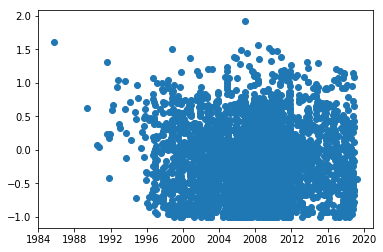

In [408]:

myplot = plt.scatter(df['release_date'],df['total_shipped'].apply(np.log10),)


In [501]:
df['position'] = df['position'].astype(int)

In [502]:
df['release_year'] = df['release_date'].apply(lambda element: element.year)

In [503]:
df.head()

,index,position,game,console,publisher,total_shipped,release_date,average_rating,release_year
8299,12301,12302,Dungeons & Dragons Tactics,PSP,Atari,0.1,2007-08-14,5.2,2007
3704,12320,12321,Hunter: The Reckoning,GC,Interplay,0.1,2002-11-18,7.1,2002
2453,12430,12431,Aidyn Chronicles: The First Mage,N64,THQ,0.1,2001-03-14,6.0,2001
12083,12220,12221,JU-ON: The Grudge,Wii,Xseed Games,0.1,2009-10-13,4.0,2009
7811,12426,12427,Bullet Witch,X360,Atari,0.1,2007-02-27,6.6,2007


In [504]:
df.sort_values(by = 'position')

,index,position,game,console,publisher,total_shipped,release_date,average_rating,release_year
7608,0,1,Wii Sports,Wii,Nintendo,82.86,2006-11-19,7.700000,2006
141,1,2,Super Mario Bros.,NES,Nintendo,40.24,1985-10-18,9.100000,1985
9438,2,3,Mario Kart Wii,Wii,Nintendo,37.14,2008-04-27,8.666667,2008
11649,4,5,Wii Sports Resort,Wii,Nintendo,33.09,2009-07-26,8.533333,2009
1487,5,6,Pokémon Red / Green / Blue Version,GB,Nintendo,31.38,1998-09-30,9.400000,1998
6929,6,7,New Super Mario Bros.,DS,Nintendo,30.80,2006-05-15,8.600000,2006
12412,8,9,New Super Mario Bros. Wii,Wii,Nintendo,30.22,2009-11-15,8.966667,2009
13009,9,10,Minecraft,PC,Mojang,30.01,2010-05-10,10.000000,2010
7773,11,12,Wii Play,Wii,Nintendo,28.02,2007-02-12,5.233333,2007
13814,12,13,Kinect Adventures!,X360,Microsoft Game Studios,24.00,2010-11-04,6.450000,2010


# Things to be aware of:

- Some games were sold in packages (duck hunt, super mario)

- Some games were packaged with console ( wii sports)

- Calculate holidays based on US and East Asia (China, SK, Japan) will be about 75% of all consumers based off newZoo market research 2018

In [505]:
# We cut out 
df_no_release_date.shape

(522, 15)

In [506]:
df_sorted_by_date.shape

(20689, 15)

In [632]:
# Set the range for days before holidays to look at
day_range = 4

def make_set_of_near_holidays(country,day_range):
    # Takes workalendar Country() object and makes a set of holidays between 1983 and 2018. Note:\
    # does not work on China, because China has insufficient data (holiday data only to 2018)
    set_of_near_holidays=set()
    # Number of days to include before holidays + 1 
    for year in range(1983,2019):
        for day_tuple in country.holidays(year):
            set_of_near_holidays.add(day_tuple[0]);
            for day_count in range(1,day_range):
                set_of_near_holidays.add(day_tuple[0] - dt.timedelta(days =day_count))
            #set_of_near_holidays.append(day_tuple[0]) - dt.timedelta(days = 1);
    # Save unique holidays
    return (set_of_near_holidays)


In [724]:
# These three countries capture ~75% of market according to Newzoo market data for 2018. Therefore we'll look
# at market data for just these.

us_holidays = make_set_of_near_holidays(UnitedStates(),day_range)
south_korea_holidays = make_set_of_near_holidays(SouthKorea(),day_range);
japan_holidays = make_set_of_near_holidays(Japan(),day_range)
# workalendar package only includes 2018 data for China, so it needs its own code. We'll approximate\
# the past years' holiday dates as close to 2018 dates.
china_holidays = set()
for date_tuple in China().holidays(2018):
    china_holidays.add(date_tuple[0])
    for day_count in range(1,day_range):
        china_holidays.add(date_tuple[0] - dt.timedelta(days = day_count))


/anaconda3/lib/python3.7/site-packages/workalendar/asia/china.py:63: UserWarning: Support 2018, 2019 currently, need update every year.
  warnings.warn("Support 2018, 2019 currently, need update every year.")


In [716]:
# Convert from pandas Timestamp to python datetime
df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())

In [721]:
df['near_us_holiday'] = df['release_date'].apply(lambda x: x in us_holidays)
df['near_sk_holiday'] = df['release_date'].apply(lambda x: x in south_korea_holidays)
df['near_jp_holiday'] = df['release_date'].apply(lambda x: x in japan_holidays)

In [733]:
def convert_day_to_2018(input_datetime):
    if(input_datetime.month == 2 and input_datetime.day == 29):
        day_corrected = input_datetime.day - 1
    else:
        day_corrected = input_datetime.day
        
    return dt.date(year = 2018, month = input_datetime.month, day = day_corrected)
df['near_cn_holiday'] = df['release_date'].apply(lambda x: convert_day_to_2018(x) in china_holidays)

In [756]:
df['years_since_release'] = dt.datetime.now().year - df['release_year']

In [763]:
df = df.drop(columns='index')


KeyError: "['index'] not found in axis"

In [765]:
df.sort_values(by = 'position')

,position,game,console,publisher,total_shipped,release_date,average_rating,release_year,near_us_holiday,near_sk_holiday,near_jp_holiday,near_cn_holiday,years_since_release
7608,1,Wii Sports,Wii,Nintendo,82.86,2006-11-19,7.700000,2006,False,False,False,False,13
141,2,Super Mario Bros.,NES,Nintendo,40.24,1985-10-18,9.100000,1985,False,False,False,False,34
9438,3,Mario Kart Wii,Wii,Nintendo,37.14,2008-04-27,8.666667,2008,False,False,True,True,11
11649,5,Wii Sports Resort,Wii,Nintendo,33.09,2009-07-26,8.533333,2009,False,False,False,False,10
1487,6,Pokémon Red / Green / Blue Version,GB,Nintendo,31.38,1998-09-30,9.400000,1998,False,True,False,True,21
6929,7,New Super Mario Bros.,DS,Nintendo,30.80,2006-05-15,8.600000,2006,False,False,False,False,13
12412,9,New Super Mario Bros. Wii,Wii,Nintendo,30.22,2009-11-15,8.966667,2009,False,False,False,False,10
13009,10,Minecraft,PC,Mojang,30.01,2010-05-10,10.000000,2010,False,False,False,False,9
7773,12,Wii Play,Wii,Nintendo,28.02,2007-02-12,5.233333,2007,False,False,False,True,12
13814,13,Kinect Adventures!,X360,Microsoft Game Studios,24.00,2010-11-04,6.450000,2010,False,False,False,False,9


# Workflow - Project 2


## Compare features

- pair plots
- bar charts
- group by time

## Read online sources

- what do experts say will increase target variable

## Hypothesis what linear model may tell you

- what are expectations

## Fit basic model before feature manipulation

- see if statistics are stastically sig
- normally distributed residuals
- check null hypothesis, p value
- this is baseline model
- standardize features

## Try polynomial fitting , LR_2, LR_custom feature extraction

- Compare different iterations

## Regularization

- Polynomial to 3rd or 4th degree / transforms to try to normally distribute
- increase lambda slowly to see when results give low error
- that is ideal level of complexity

## Other things:

- Start **TOO COMPLEX** before grid search
- Need to be 'to the right' of optimal point

### Grid search
- for regularization
- use log scale for lambda .0001 to 100,000
- for alpha and complement > 0 to 1
- for each  alpha and lambda, cross validate 
- sk learn will give you best model parameters
    - choose best model based on stuff like meansquared error on out of smaple data
- after finding model, you are **done**

### Pipeline
- for this project, don't need to mess with it

In [772]:
df.iloc[:,:]

,position,game,console,publisher,total_shipped,release_date,average_rating,release_year,near_us_holiday,near_sk_holiday,near_jp_holiday,near_cn_holiday,years_since_release
8299,12302,Dungeons & Dragons Tactics,PSP,Atari,0.10,2007-08-14,5.200000,2007,False,True,False,False,12
3704,12321,Hunter: The Reckoning,GC,Interplay,0.10,2002-11-18,7.100000,2002,False,False,False,False,17
2453,12431,Aidyn Chronicles: The First Mage,N64,THQ,0.10,2001-03-14,6.000000,2001,False,False,False,False,18
12083,12221,JU-ON: The Grudge,Wii,Xseed Games,0.10,2009-10-13,4.000000,2009,False,False,False,False,10
7811,12427,Bullet Witch,X360,Atari,0.10,2007-02-27,6.600000,2007,False,True,False,False,12
7766,12607,Ar tonelico: Melody of Elemia,PS2,Nippon Ichi Software,0.10,2007-02-06,7.000000,2007,False,False,False,False,12
14080,12634,MindJack,X360,Square Enix,0.10,2011-01-18,4.500000,2011,False,False,False,False,8
7683,12189,Disney's Chicken Little: Ace In Action,Wii,Buena Vista,0.10,2006-12-11,7.600000,2006,False,False,False,False,13
18967,12593,Shantae and the Pirate's Curse,3DS,WayForward Technologies,0.10,2016-10-18,7.700000,2016,False,False,False,False,3
8070,12334,Surf's Up,X360,Ubisoft,0.10,2007-05-30,6.200000,2007,False,False,False,False,12
